# Comparison B-JointSP vs RL

![abilene](../abilene-rand-cap.jpg)

Black numbers = pop IDs. Red numbers = link delays (in ms).

## Scenario

* Abilene network
* All nodes with random cap between 0-2
* 5 scenarios with 1-5 ingress nodes
* Random flow arrival with inter-arr time 10
* Flow weight = 1, Delay weight = 0

## Approaches

* B-JointSP: 30 repetition per scenario
* Load Balance: 30 repetition per scenario
* Shortest Path: 30 repetition per scenario
* Random Schedule : 30 repetition per scenario
* DDPG: 
  * 100k training with 10 different seeds --> auto select best one
  * 30x 1 testing episode with best agent

In [1]:
import os
import pandas as pd
import yaml
from operator import itemgetter
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def read_results(dir, df=None, rf=None, best_only=False):
    """Read result files in the directory and append results to the data frame"""
    if df is None:
        df = pd.DataFrame()
    if rf is None:
        rf = pd.DataFrame()
    
    for root, sub_dirs, files in os.walk(dir):
        if len(files) > 0:
            if 'best' in root or not best_only:
                # read metrics at end of simulation (last row)
                df_metrics = pd.read_csv(f'{root}/metrics.csv')
                data = df_metrics.tail(1)
                # get the last placement
                df_placements = pd.read_csv(f'{root}/placements.csv').groupby('time')
                placements = pd.concat(deque(map(itemgetter(1), df_placements), maxlen=1))
                                
                # add algorithm name, number of ingress nodes, and number of vnfs as columns
                with open(f'{root}/input.yaml', 'r') as f:
                    inputs = yaml.load(f, Loader=yaml.Loader)
                data.insert(loc=0, column='algorithm', value=inputs['algorithm'])
                data.insert(loc=1, column='num_ingress', value=inputs['num_ingress'])
                data.insert(loc=data.columns.size, column='num_vnfs', value=placements['sf'].size)
                df = df.append(data, ignore_index=True, sort=True)
                fix_dtypes(df)
                df.sort_values(['algorithm', 'num_ingress'], inplace=True)
                df = df[['algorithm', 'num_ingress', 'total_flows', 'successful_flows', 'dropped_flows', 'in_network_flows', 'avg_end2end_delay', 'num_vnfs']]
                
                # Reading resource metrics and creating a new Resource Dataframe
                # Getting the last group using the Deque operation
                rf_resources = pd.read_csv(f'{root}/resources.csv').groupby('time')
                resources = pd.concat(deque(map(itemgetter(1), rf_resources), maxlen=1))
                resources.insert(loc=0, column='algorithm', value=inputs['algorithm'])
                resources.insert(loc=1, column='num_ingress', value=inputs['num_ingress'])
                rf = rf.append(resources, ignore_index=True, sort=True)
                rf.sort_values(['algorithm', 'num_ingress'], inplace=True)
                
    #Add percentage of successful flows
    succ_percentage = []
    for index, row in df.iterrows():
        succ_percentage.append(row['successful_flows'] / row['total_flows'] * 100)
    df['successful_percentage'] = succ_percentage 
    return df, rf


def fix_dtypes(df):
    """Set correct dtypes and order"""
    df['avg_end2end_delay'] = pd.to_numeric(df['avg_end2end_delay'])
    df['total_flows'] = pd.to_numeric(df['total_flows'])
    df['successful_flows'] = pd.to_numeric(df['successful_flows'])
    df['dropped_flows'] = pd.to_numeric(df['dropped_flows'])
    df['in_network_flows'] = pd.to_numeric(df['in_network_flows'])
    
    
def df_mean_std(df, group_by=['algorithm', 'num_ingress']):
    """Return 2 new dfs with 1) average and 2) std values"""
    df_mean = df.groupby(group_by).mean().reset_index()
    df_std = df.groupby(group_by).std().reset_index()
    return df_mean, df_std

In [3]:
# read results
df = pd.DataFrame()
rf = pd.DataFrame()
df, rf = read_results('BJointSP-default', df, rf, best_only=False)
df, rf = read_results('BJointSP-fixed', df, rf, best_only=False)
df, rf = read_results('Load Balance updated', df, rf, best_only=False)
df, rf = read_results('Shortest Path', df, rf, best_only=False)
#df, rf = read_results('Random Schedule', df, rf, best_only=False)
df, rf = read_results('DRL-10x-100k', df, rf, best_only=True)

df_mean, df_std = df_mean_std(df)
rf, _ = df_mean_std(rf, group_by=['algorithm', 'num_ingress', 'node'])
df = df_mean
df.algorithm.replace(['BJointSP-Default', 'BJointSP-Fixed', 'DDPG' , 'RS' ], ['BSP Default', 'BSP Fixed', 'DRL', 'Rand'], inplace=True)
df_mean.algorithm.replace(['BJointSP-Default', 'BJointSP-Fixed', 'DDPG' , 'RS' ], ['BSP Default', 'BSP Fixed', 'DRL', 'Rand'], inplace=True)
df_std.algorithm.replace(['BJointSP-Default', 'BJointSP-Fixed', 'DDPG' , 'RS' ], ['BSP Default', 'BSP Fixed', 'DRL', 'Rand'], inplace=True)
rf.algorithm.replace(['BJointSP-Default', 'BJointSP-Fixed', 'DDPG' , 'RS' ], ['BSP Default', 'BSP Fixed', 'DRL', 'Rand'], inplace=True)

display(df_mean)
display(df_std)
display(rf)

,algorithm,num_ingress,total_flows,successful_flows,dropped_flows,in_network_flows,avg_end2end_delay,num_vnfs,successful_percentage
0,BSP Default,1,2005.600000,815.100000,1188.100000,2.400000,30.973110,20.800000,40.672165
1,BSP Default,2,3983.466667,918.533333,3060.800000,4.133333,30.088910,28.900000,23.060030
2,BSP Default,3,6007.400000,1119.666667,4882.400000,5.333333,31.301458,32.066667,18.640179
3,BSP Default,4,8012.900000,1214.233333,6792.233333,6.433333,30.474906,32.966667,15.154056
4,BSP Default,5,10026.333333,1266.766667,8752.500000,7.066667,30.282139,33.000000,12.635457
5,BSP Fixed,1,2002.133333,1258.833333,741.966667,1.333333,23.782098,3.100000,62.884834
6,BSP Fixed,2,4021.600000,2491.533333,1526.266667,3.800000,27.942661,4.700000,61.957009
7,BSP Fixed,3,5991.666667,3661.866667,2324.033333,5.766667,26.918604,7.400000,61.119442
8,BSP Fixed,4,8026.633333,3713.766667,4306.800000,6.066667,24.372845,10.366667,46.273387
9,BSP Fixed,5,10034.433333,3483.900000,6544.066667,6.466667,22.826697,12.033333,34.721928


,algorithm,num_ingress,total_flows,successful_flows,dropped_flows,in_network_flows,avg_end2end_delay,num_vnfs,successful_percentage
0,BSP Default,1,44.390586,23.285855,58.469768,1.588754,0.309701,5.019960,1.781475
1,BSP Default,2,54.194244,28.962203,53.909503,1.431983,0.266412,1.470398,0.705849
2,BSP Default,3,75.350034,28.593866,76.779397,2.170862,0.142380,1.362891,0.499492
3,BSP Default,4,95.374163,29.636514,89.493472,1.977169,0.164592,0.182574,0.349164
4,BSP Default,5,103.128087,21.911552,102.723851,1.638614,0.242699,0.000000,0.242135
5,BSP Fixed,1,43.548414,22.308315,29.561722,0.844182,0.910898,0.547723,0.838492
6,BSP Fixed,2,72.887064,47.913524,45.771496,1.669193,0.520610,0.836660,0.766094
7,BSP Fixed,3,79.837911,58.667816,67.717203,1.524135,0.200115,0.855006,0.855000
8,BSP Fixed,4,91.024242,39.197716,95.890527,1.700575,0.194177,0.964305,0.687292
9,BSP Fixed,5,86.493246,57.865689,104.086480,1.888866,0.165782,0.556053,0.645898


,algorithm,num_ingress,node,episode,node_capacity,time,used_resources
0,BSP Default,1,pop0,1,0,20000.0,0.000000
1,BSP Default,1,pop1,1,1,20000.0,0.933333
2,BSP Default,1,pop10,1,1,20000.0,0.833333
3,BSP Default,1,pop2,1,0,20000.0,0.000000
4,BSP Default,1,pop3,1,2,20000.0,1.700000
...,...,...,...,...,...,...,...
270,SP,5,pop5,1,2,20000.0,1.866667
271,SP,5,pop6,1,0,20000.0,0.000000
272,SP,5,pop7,1,0,20000.0,0.000000
273,SP,5,pop8,1,2,20000.0,1.000000


## Plotting Total_Flows, Successful_Flows and Dropped_Flows

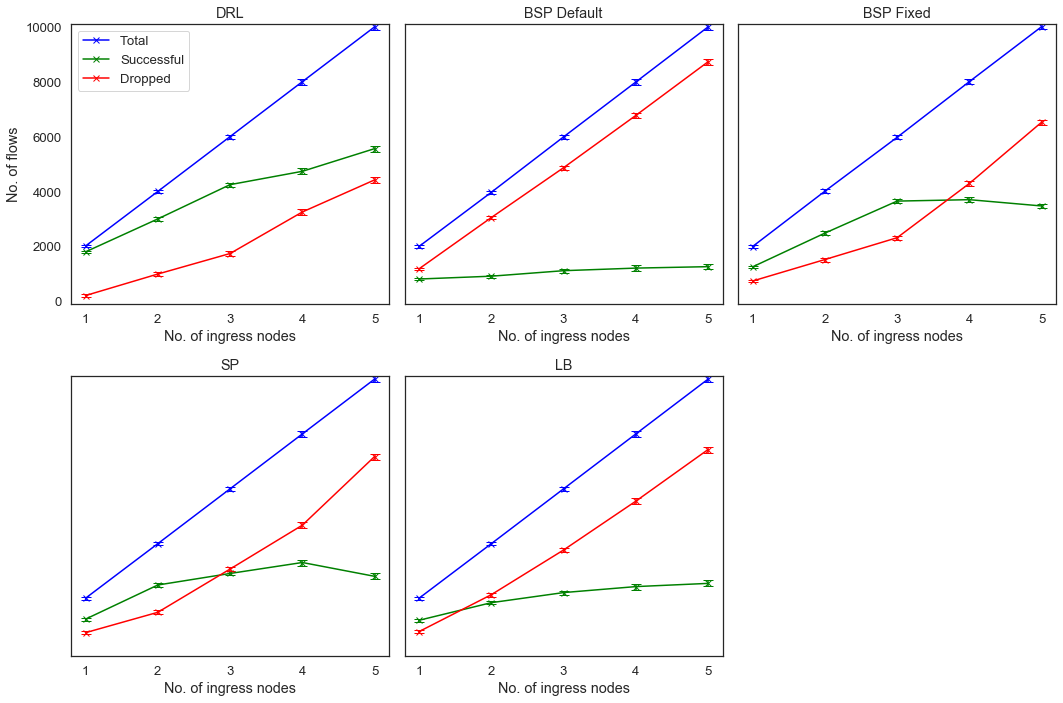

In [4]:
algs=['DRL','BSP Default','BSP Fixed', 'SP', 'LB']

def plot_flows(df_mean, df_std, algs=algs, filename=None):
    """Plot (and save) total, successful, dropped flows of diff. algorithms over #ingress"""
    sns.set(font_scale=1.2, style='white')

    # Different graphs for each Algo for better clarity 
    fig = plt.figure(figsize=(15, 10))
    for i, alg in enumerate(algs):
        ax = plt.subplot(2, 3, i + 1)
        # get sub-df for specific algorithm
        alg_df_mean = df_mean[df_mean['algorithm'] == alg]
        alg_df_std = df_std[df_std['algorithm'] == alg]
        
        ax.errorbar(alg_df_mean['num_ingress'], alg_df_mean['total_flows'], yerr=alg_df_std['total_flows'], capsize=5,
                label='Total', color='blue', marker='x')
        ax.errorbar(alg_df_mean['num_ingress'], alg_df_mean['successful_flows'], yerr=alg_df_std['total_flows'], capsize=5,
                label='Successful', color='green', marker='x')
        ax.errorbar(alg_df_mean['num_ingress'], alg_df_mean['dropped_flows'], yerr=alg_df_std['total_flows'], capsize=5,
                label='Dropped', color='red', marker='x')

        plt.title(f"{alg}")
        ax.set_xlabel('No. of ingress nodes')
        plt.xticks(range(df_mean['num_ingress'].min(), df_mean['num_ingress'].max() + 1))
        y_buffer = 100
        plt.ylim([0-y_buffer, max(df_mean['total_flows'])+y_buffer])
        # plot y labels and legend only once
        if i == 0:
            ax.set_ylabel('No. of flows')
            # plot legend without errorbars by getting handles and removing errorbars there
            handles, labels = ax.get_legend_handles_labels()
            handles = [h[0] for h in handles]
            ax.legend(handles, labels, loc='upper left',numpoints=1)
        else:
            ax.set_yticklabels([])

    if filename is not None:
        plt.tight_layout()
        fig.savefig(filename)
        
plot_flows(df_mean, df_std, filename='../plots/rand-fixed-randcap-flows.pdf')

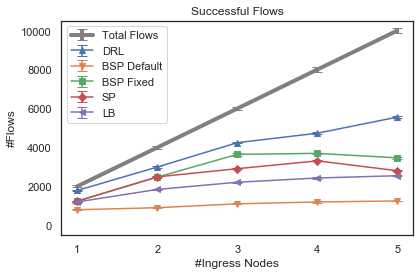

In [5]:
sns.set(font_scale=1, style='white')
markers = ['^', 'v', 's', 'D', '<', '>', 'P', 'X', 'o', '8', 'p']
# hsla(125, 100%, 20%, 1) +10% brightness. https://www.hexcolortool.com/#00990d
greens = ['#006609', '#00990d', '#00cc11', '#00ff15', '#4e5700', '#306e7e']
# https://www.hexcolortool.com/#660000
reds = ['#660000', '#990000', '#cc0000', '#ff0000', '#ffadad', '#290000']

# single plot with successful flows
fig, ax1 = plt.subplots(ncols=1)

# FIXME: not all algorithms have the same number of total flows currently!
# plot total flows (just from one alg; should be similar)
df_ddpg = df[df['algorithm'] == 'DRL']
df_std_ddpg = df_std[df_std['algorithm'] == 'DRL']
ax1.errorbar(df_ddpg['num_ingress'], df_ddpg['total_flows'], yerr=df_std_ddpg['total_flows'], capsize=5,
             label='Total Flows', color='grey', linewidth=4)
#ax2.plot(df_ddpg['num_ingress'], df_ddpg['total_flows'], label='Total Flows', color='grey', linewidth=4)

# plot successful flows
for i, algorithm in enumerate(algs):
    alg_df_mean = df_mean[df_mean['algorithm'] == algorithm]
    alg_df_std = df_std[df_std['algorithm'] == algorithm]
        
    ax1.errorbar(alg_df_mean['num_ingress'], alg_df_mean['successful_flows'], yerr=alg_df_std['successful_flows'], capsize=5,
                label='{}'.format(algorithm), marker=markers[i])
    #ax2.errorbar(alg_df_mean['num_ingress'], alg_df_mean['dropped_flows'], yerr=alg_df_std['dropped_flows'], capsize=5,
    #            label='{}'.format(algorithm), marker=markers[i], color=reds[i])


# important: use same scale for both plots!
y_buffer = 500
ax1.set_ylim([0-y_buffer, max(df_mean['total_flows'])+y_buffer])
#ax2.set_ylim([0-y_buffer, max(df_mean['total_flows'])+y_buffer])

# set axis, title, legend
ax1.set_title('Successful Flows')
#ax2.set_title('Dropped Flows')
ax1.set_xlabel('#Ingress Nodes')
#ax2.set_xlabel('#Ingress Nodes')
ax1.set_xticks(range(df['num_ingress'].min(), df['num_ingress'].max() + 1))
#ax2.set_xticks(range(df['num_ingress'].min(), df['num_ingress'].max() + 1))
ax1.set_ylabel('#Flows')
#ax2.set_yticklabels([])

ax1.legend()
#ax2.legend()

plt.tight_layout()
fig.savefig('../plots/rand-fixed-randcap-flows.pdf')

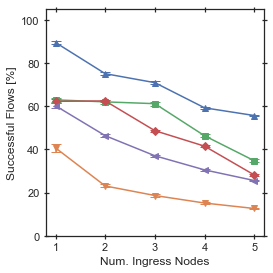

In [6]:
# single plot with %age successful flows
fig, ax1 = plt.subplots(figsize=(4, 4))
sns.set(font_scale=1.1, style='white')

# plot successful flows
for i, algorithm in enumerate(algs):
    alg_df_mean = df_mean[df_mean['algorithm'] == algorithm]
    alg_df_std = df_std[df_std['algorithm'] == algorithm]
    ax1.errorbar(alg_df_mean['num_ingress'], alg_df_mean['successful_percentage'], yerr=alg_df_std['successful_percentage'], capsize=5,
                label='{}'.format(algorithm), marker=markers[i])
    
# set axis, title, legend
# ax1.set_title('Successful Flows')
ax1.set_xlabel('Num. Ingress Nodes')
ax1.set_xticks(range(df['num_ingress'].min(), df['num_ingress'].max() + 1))
ax1.set_ylabel('Successful Flows [%]')
ax1.set_ylim(0, 105)

ax1.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)

# # remove error bars from legend: https://stackoverflow.com/a/15551976/2745116
# # get handles
# handles, labels = ax1.get_legend_handles_labels()
# # remove the errorbars
# handles = [h[0] for h in handles]
# # use them in the legend
# ax1.legend(handles, labels, numpoints=1)

# ax1.legend()

plt.tight_layout()
fig.savefig('../plots/rand-fixed-randcap-percent-successful-flows.pdf')

In [7]:
# calculate max difference between DDPG and B-JointSP fixed
ddpg_successful = list(df[df['algorithm'] == 'DRL']['successful_percentage'])
bjointsp_successful = list(df[df['algorithm'] == 'BSP Fixed']['successful_percentage'])

divs = [ddpg_successful[i] / bjointsp_successful[i] for i in range(len(ddpg_successful))]
print(f'DRL / BSP Fixed: {divs}. Max-1: {max(divs)-1}')

divs = [bjointsp_successful[i] / ddpg_successful[i] for i in range(len(ddpg_successful))]
print(f'BSP Fixed / DRL: {divs}. 1-Min: {1-min(divs)}')

DRL / BSP Fixed: [1.4217795243430864, 1.2104576043184039, 1.1589761875028495, 1.2793419019405916, 1.6022905068323503]. Max-1: 0.6022905068323503
BSP Fixed / DRL: [0.7033439312343707, 0.8261338492421547, 0.862830497108502, 0.7816518777999321, 0.6241065498022271]. 1-Min: 0.37589345019777287


In [8]:
# calculate max difference between DDPG and B-JointSP default
ddpg_successful = list(df[df['algorithm'] == 'DRL']['successful_flows'])
bjointsp_successful = list(df[df['algorithm'] == 'BSP Default']['successful_flows'])

divs = [ddpg_successful[i] / bjointsp_successful[i] for i in range(len(ddpg_successful))]
print(f'DRL / BSP Default: {divs}. Max-1: {max(divs)-1}')

divs = [bjointsp_successful[i] / ddpg_successful[i] for i in range(len(ddpg_successful))]
print(f'BSP Default / DRL: {divs}. 1-Min: {1-min(divs)}')

DRL / BSP Default: [2.2172330593383225, 3.2772898824212517, 3.807055671330753, 3.9114118648255416, 4.403283951267006]. Max-1: 3.4032839512670057
BSP Default / DRL: [0.45101257884835294, 0.30513016421397643, 0.262670180404914, 0.2556621584632337, 0.2271032281968232]. 1-Min: 0.7728967718031768


## Plotting Average End-to-End Delay

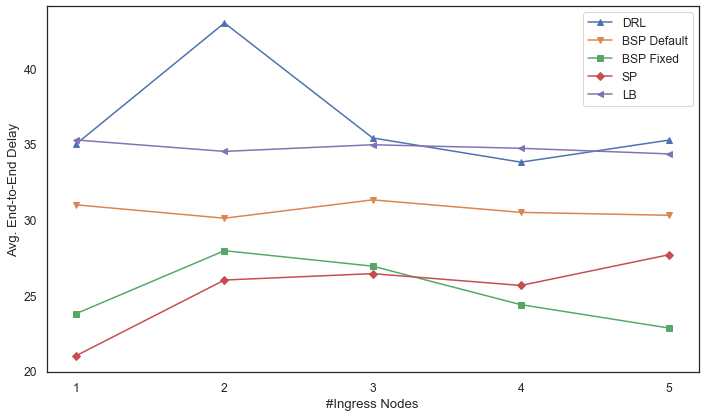

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
for i, algorithm in enumerate(algs):
    algorithm_df = df[df['algorithm'] == algorithm]
    ax.plot(algorithm_df['num_ingress'], algorithm_df['avg_end2end_delay'], 
            label=algorithm, marker=markers[i])
     
# plt.title("Avg. End-to-End Delay")
ax.set_xlabel('#Ingress Nodes')
ax.set_ylabel('Avg. End-to-End Delay')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend()
plt.xticks(range(df['num_ingress'].min(), df['num_ingress'].max() + 1))
plt.tight_layout()
fig.savefig('../plots/rand-fixed-randcap-delay.pdf')

## Plotting Overall Utility

Let's combine successful flows and delay into a single utility metric. This utility is what we optimize in RL as reward.

In [10]:
# calculate and add utility values
def flow_utility(df):
    """For the given DataFrame with successful and dropped flows, return the flow utility/reward in [-1,1]."""
    return (df['successful_flows'] - df['dropped_flows']) / (df['successful_flows'] + df['dropped_flows'])

def delay_utility(df, min_delay, max_delay):
    """
    Return link utility/reward in [-1,0] for the given df, ie, (min-d)/(max-min).
    min_delay should be sum of VNF delays
    max_delay should be sum of VNF delays + num_vnfs * network_diameter
    """
    return (min_delay - df['avg_end2end_delay']) / (max_delay - min_delay)

def set_utility(df, alpha):
    """
    Calculate and set utility/reward defined as: alpha x flow_utility + (1-alpha) x delay_utility
    """
    df['flow_utility'] = flow_utility(df)
    # for SFC abc, vnf_delay=min_delay=3x5=15
    # for Abilene, diameter=15 --> max_delay = 15 + 3x15 = 60
    df['delay_utility'] = delay_utility(df, min_delay=15, max_delay=60)
    df['utility'] = alpha * df['flow_utility'] + (1-alpha) * df['delay_utility']
    
set_utility(df, alpha=1)
df
rf

,algorithm,num_ingress,node,episode,node_capacity,time,used_resources
0,BSP Default,1,pop0,1,0,20000.0,0.000000
1,BSP Default,1,pop1,1,1,20000.0,0.933333
2,BSP Default,1,pop10,1,1,20000.0,0.833333
3,BSP Default,1,pop2,1,0,20000.0,0.000000
4,BSP Default,1,pop3,1,2,20000.0,1.700000
...,...,...,...,...,...,...,...
270,SP,5,pop5,1,2,20000.0,1.866667
271,SP,5,pop6,1,0,20000.0,0.000000
272,SP,5,pop7,1,0,20000.0,0.000000
273,SP,5,pop8,1,2,20000.0,1.000000


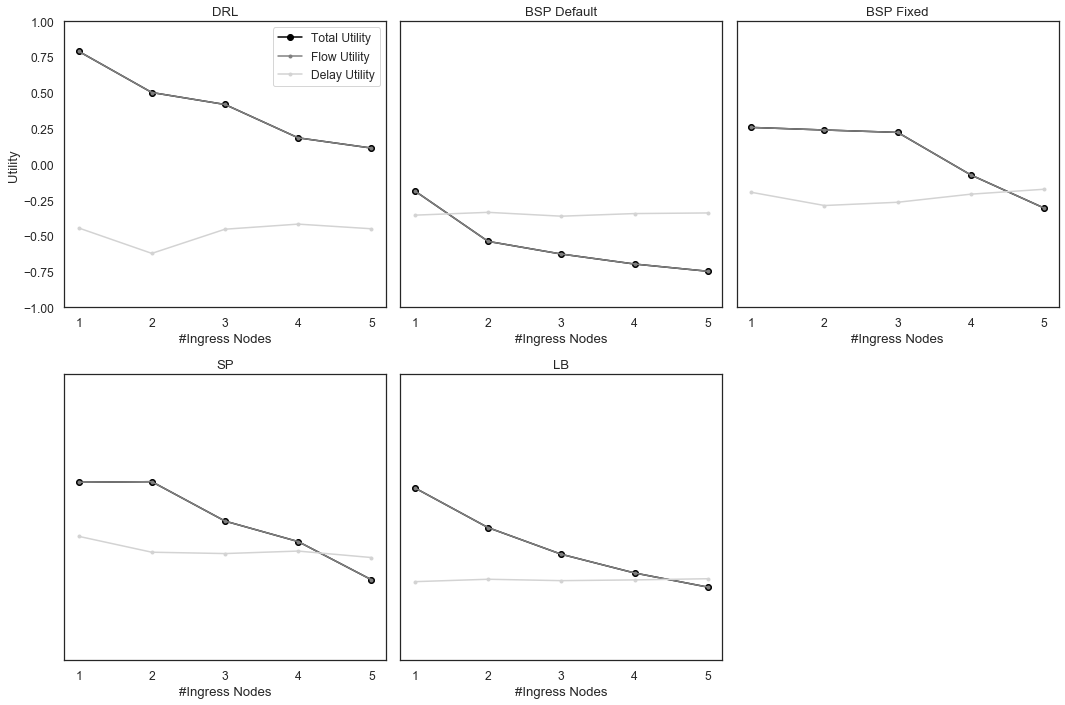

In [11]:
# plot utility
num_algo = np.unique(df.algorithm.values).size

# Different graphs for each Algo for better clarity 
fig = plt.figure(figsize=(15,10))
for i, algorithm in enumerate(algs):
    algorithm_df = df[df['algorithm'] == algorithm]
    ax = plt.subplot(2, 3, i + 1)
    ax.plot(algorithm_df['num_ingress'], algorithm_df['utility'], 
            label='Total Utility', color='black', marker='o')
    ax.plot(algorithm_df['num_ingress'], algorithm_df['flow_utility'], 
            label='Flow Utility', color='grey', marker='.')
    ax.plot(algorithm_df['num_ingress'], algorithm_df['delay_utility'], 
            label='Delay Utility', color='lightgrey', marker='.')
     
    plt.title("{}".format(algorithm))
    ax.set_xlabel('#Ingress Nodes')
    plt.xticks(range(df['num_ingress'].min(), df['num_ingress'].max() + 1))
    ax.set_ylim(-1, 1)
    
    if i == 0:
        ax.set_ylabel('Utility')
        ax.legend()
    else:
        ax.set_yticklabels([])

plt.tight_layout()
fig.savefig('../plots/rand-fixed-randcap-utility.pdf')

## Number of placed VNF instances

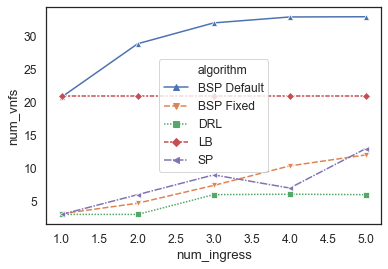

In [12]:
sns.lineplot(df['num_ingress'], df['num_vnfs'], hue=df['algorithm'], markers=markers, style=df['algorithm'])

## Used resources

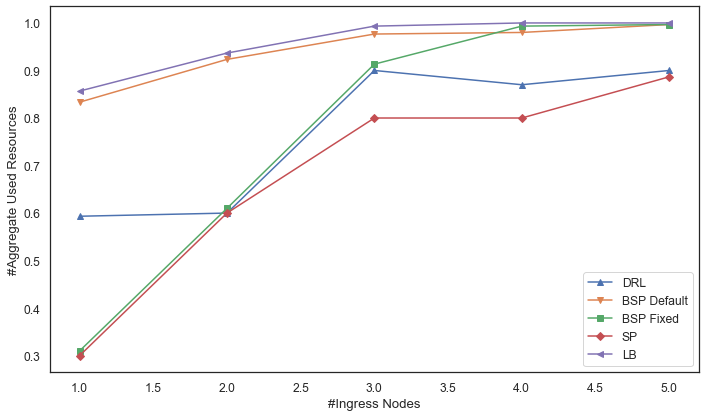

In [13]:
# Aggregated Used Resourced per Algorithm (Total Capacity for all nodes / Used Capacity by all Nodes )
fig, ax = plt.subplots(figsize=(10,6))
for i, algorithm in enumerate(algs):
    algorithm_df = rf[rf['algorithm'] == algorithm]
    aggregate_values = []
    ingress = []
    for ingress_group in algorithm_df.groupby('num_ingress'):
        ingress_df = pd.DataFrame(ingress_group[1])
        tot_used_cap = ingress_df['used_resources'].sum()
        tot_node_cap = ingress_df['node_capacity'].sum()
        ingress.append(ingress_group[0])
        aggregate_values.append(tot_used_cap/tot_node_cap)
    ax.plot(ingress, aggregate_values, label=algorithm,
            marker=markers[i])
plt.xlabel('#Ingress Nodes')
plt.ylabel('#Aggregate Used Resources')
ax.legend()

plt.tight_layout()

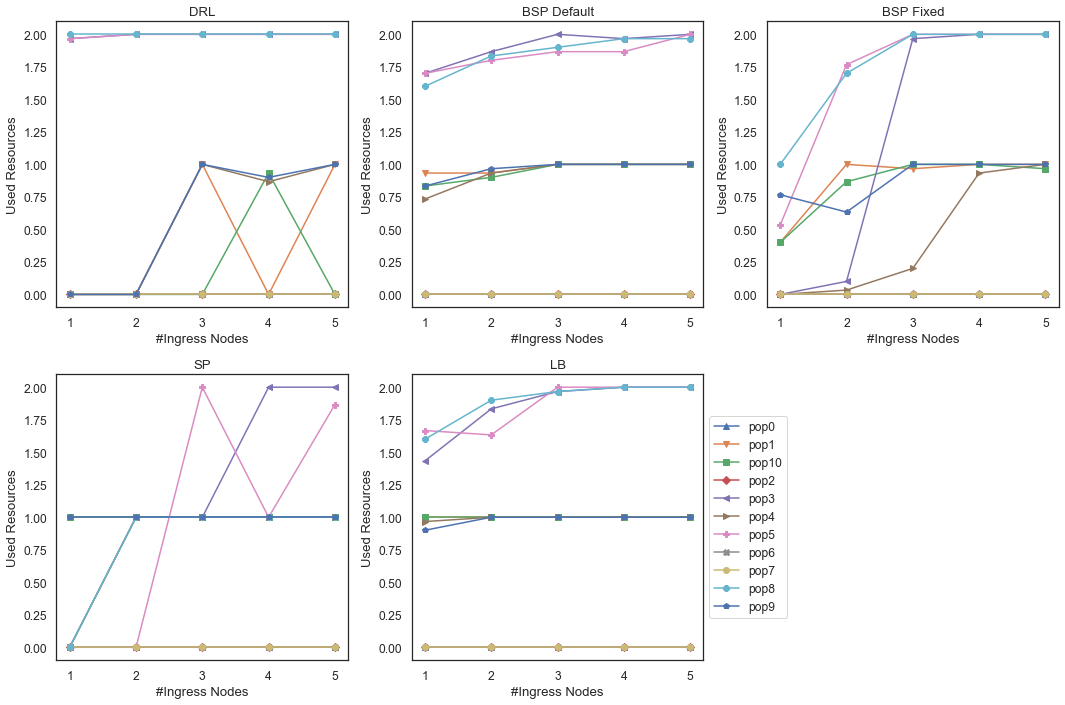

In [14]:
# Used Capacity per node per ALgorithm 
plt.figure(figsize=(15, 10))
for i, algorithm in enumerate(algs):
    algorithm_df = rf[rf['algorithm'] == algorithm]
    ax = plt.subplot(2, 3, i + 1)
    for j, node in enumerate(algorithm_df.groupby('node')):
        node_df = pd.DataFrame(node[1])
        ax.plot(node_df['num_ingress'], node_df['used_resources'], label=node[0],
                marker=markers[j % len(markers)])
    ax.set_xlabel('#Ingress Nodes')
    ax.set_ylabel('Used Resources')
    plt.title("{}".format(algorithm))
    
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()